In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets
from torchvision import transforms 
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
data_dir = '/kaggle/input/5class-weather-status-image-classification'

In [ ]:
from torch.utils.data import Dataset
import glob
import cv2
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(root_dir + '*/*') # 전체 파일 받아오기

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)

        transformed_image = self.transform(image)

        label_dict = {
            'cloudy' : 0,
            'foggy' : 1,
            'rainy'  : 2,
            'snowy' : 3,
            'sunny' : 4
        }
        label = image_filepath.split('/')[-2]

        return transformed_image, label_dict[label]

In [ ]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

In [ ]:
dataset_custom = MyDataset(root_dir = data_dir, transform = transform)

In [ ]:
dataset_auto = datasets.ImageFolder(data_dir, transform = transform)

In [ ]:
print('custom', len(dataset_custom))
print('auto', len(dataset_auto))

custom 18039
auto 18038


In [ ]:
dataset_custom

In [ ]:
dataset_auto

Dataset ImageFolder
    Number of datapoints: 18038
    Root location: ./weather/data/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [ ]:
def train_test_valid(dataset, valid_ratio, test_ratio):
    cloudy_list = []
    foggy_list = []
    rainy_list = []
    snowy_list = []
    sunny_list = []

    train_idx = []
    valid_idx = []
    test_idx = []

    for i in range(len(dataset)):
        label = dataset[i][1]
        if label == 0:
            cloudy_list.append(i)
        elif label == 1:
            foggy_list.append(i)
        elif label == 2:
            rainy_list.append(i)
        elif label == 3:
            snowy_list.append(i)
        else:
            sunny_list.append(i)

    for cnt, weather_idx in enumerate((cloudy_list, foggy_list, rainy_list, snowy_list, sunny_list)):
        train_num = round(round(len(weather_idx) * (1.0 - test_ratio)) * (1.0 - valid_ratio))
        valid_num = round(round(len(weather_idx) * (1.0 - test_ratio) * valid_ratio))
        test_num = round(len(weather_idx) * test_ratio)

        train_idx += weather_idx[:train_num]
        valid_idx += weather_idx[train_num:train_num+valid_num]
        test_idx += weather_idx[train_num + valid_num:train_num + valid_num + test_num]
    
    return train_idx, valid_idx, test_idx

In [ ]:
train_idx, valid_idx, test_idx = train_test_valid(dataset_custom, valid_ratio = 0.2, test_ratio = 0.2)

print(len(train_idx), len(valid_idx), len(test_idx))

trainset = Subset(dataset_custom, train_idx)
validset = Subset(dataset_custom, valid_idx)
testset = Subset(dataset_custom, test_idx)

11546 2886 3607


In [ ]:
len(trainset)

11546

In [ ]:
train_idx, valid_idx, test_idx = train_test_valid(dataset_auto, valid_ratio = 0.2, test_ratio  = 0.2)

print(len(train_idx), len(valid_idx), len(test_idx))

trainset = Subset(dataset_auto, train_idx)
validset = Subset(dataset_auto, valid_idx)
testset = Subset(dataset_auto, test_idx)

11545 2886 3607


In [ ]:
# class_train = []
# class_valid = []
# class_test = []

# for i in range(5):
#     train_weather = 0
#     valid_weather = 0
#     test_weather = 0

#     for j in range(len(trainset)):
#         if j < len(validset):
#             if validset[j][1] == i:
#                 valid_weather += 1
#         if j < len(testset):
#             if testset[j][1] == i:
#                 test_weather += 1
#         if trainset[j][1] == i:
#             train_weather += 1

#     class_train.append(train_weather)
#     class_valid.append(valid_weather)
#     class_test.append(test_weather)

# print('train 속 weather의 개수 : ', class_train)
# print('valid 속 weather의 개수 : ', class_valid)
# print('test 속 weather의 개수 : ', class_test)

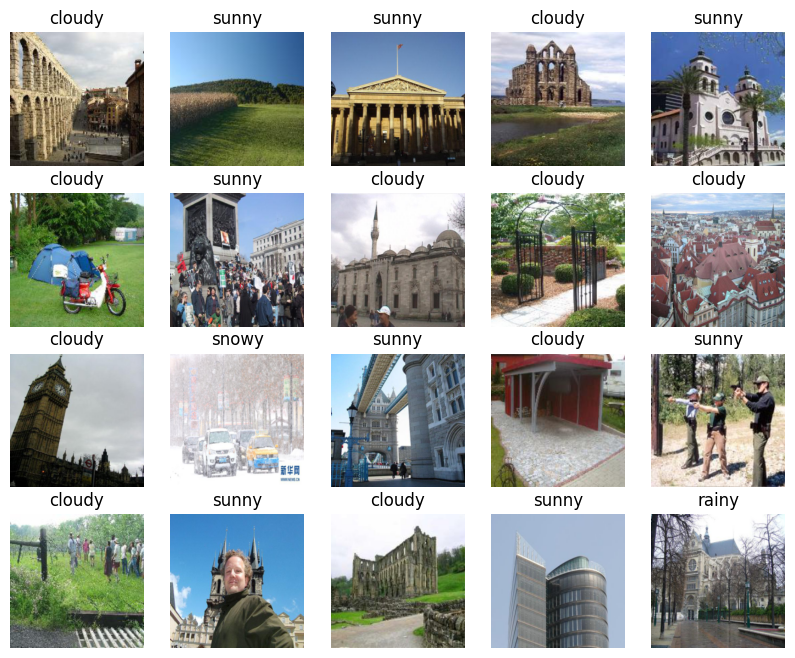

In [ ]:
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}

figure, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
axes = axes.flatten()

for i in range(20):
  rand_i = np.random.randint(0, len(trainset))
  image, label= trainset[rand_i][0], trainset[rand_i][1]
  image = torch.permute(image, (1, 2, 0)) # image.permute(1, 2, 0)
  axes[i].axis('off')
  axes[i].imshow(image)
  axes[i].set_title(labels_map[label])

plt.show()

In [ ]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 722
<class 'torch.utils.data.dataloader.DataLoader'> 181
<class 'torch.utils.data.dataloader.DataLoader'> 226


In [ ]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [ ]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

import torchvision.models as models

In [ ]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.size()[0], 784)

            # 2. 전방향(Forward) 예측
            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [ ]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7 

    for epoch in range(epochs):
        model.train() # 훈련 모드
        train_loss = 0
        for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            steps += 1
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)
 
            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.shape[0], 784) 

            # 2. 전방향(forward) 예측
            predict = model(images) # 예측 점수

            loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환
 
            # 3. 역방향(backward) 오차(Gradient) 전파
            optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
            loss.backward() # 모델파리미터들의 Gradient 전파

            # 4. 경사 하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0 : 
                model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)


                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                  'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
                  )')     

                # option 2 : valid_accuracy 모니터링      
                if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
                    max_accuracy = valid_accuracy
                    best_model_state = deepcopy(model.state_dict())          
                    torch.save(best_model_state, 'best_checkpoint.pth')  
                # -------------------------------------------

                # Early Stopping (조기 종료)
                if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                    if trigger > patience:
                        print('Early Stopping !!!')
                        print('Training loop is finished !!')
                        writer.flush()   
                        return
                else:
                    trigger = 0
                    min_loss = valid_loss
                # -------------------------------------------

                # Learning Rate Scheduler
                scheduler.step(valid_loss)
                # -------------------------------------------
        
    return  

In [ ]:
model = models.alexnet(weights=True)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:07<00:00, 30.7MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.classifier.parameters():
    parameter.requires_grad = True

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
model.classifier = nn.Sequential(
                                    nn.Linear(in_features=9216, out_features=4096, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=4096, out_features=4096, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=4096, out_features=5, bias=True)
                                )

In [ ]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [ ]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 4, verbose = True)

In [ ]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

KeyboardInterrupt: ignored